# K‑Fold Pretrain Fine Model Comparison Dashboard

This notebook loads k‑fold training histories for **multiple models**, extracts the **best epoch per fold** (based on `val_accuracy` by default), and provides **publication‑quality** comparisons:

- Summary tables per model and combined
- Boxplot of validation accuracy across folds (per model)
- Mean±SD bar charts for validation accuracy and overfitting gap
- CSV export of all summarized results

> **Assumptions:** Each fold's history is stored as a NumPy `.npy` (dict-like) with keys at least: `accuracy`, `loss`, `val_accuracy`, `val_loss`. Filenames contain `fold_{i}` so the fold number can be parsed.


In [1]:
import glob
import re
from pathlib import Path
from typing import Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from brainmet import plotting as brain_met_plt

pd.set_option("display.max_rows", 200)
pd.set_option("display.float_format", "{:.4f}".format)

## 1) Configure your models and file patterns

Edit the dictionary below so that each **key** is a human‑readable model name and each **value** is either a single **glob pattern (string)** or a **list of glob patterns** for runs that were split across multiple folders.

**Examples**
- **Single path:** `"ResNet50": "/path/to/logs/ResNet50/history_*_fold_*.npy"`
- **Split run:** `"EfficientNet": ["/path/part1/EffNet/history_*.npy", "/path/part2/EffNet/history_*.npy"]`

> The pattern must include `fold_` followed by a number (e.g., `fold_1`), which is used to map results to each fold.

In [2]:
# === EDIT ME: map model names to their glob patterns ===
MODEL_PATTERNS = {
    "ResNeXt50": ['/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/ResNeXt50/2_classes_training/pretrain_rough/resnext50_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_run_2025_12_05_15_17_28/history_resnext50_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_fold_*_run_2025_12_05_15_17_28.npy', '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/ResNeXt50/2_classes_training/pretrain_rough/resnext50_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_run_2025_12_15_20_20_53/history_resnext50_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_fold_*_run_2025_12_15_20_20_53.npy'],
    "ResNeXt101": ['/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/ResNeXt101/2_classes_training/pretrain_rough/resnext101_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_run_2025_12_16_11_25_17/history_resnext101_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_fold_*_run_2025_12_16_11_25_17.npy', '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/ResNeXt101/2_classes_training/pretrain_rough/resnext101_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_run_2025_12_26_05_05_19/history_resnext101_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_fold_*_run_2025_12_26_05_05_19.npy'],
    "ResNet152": '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/ResNet152/2_classes_training/pretrain_rough/resnet152_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_run_2025_12_04_12_52_31/history_resnet152_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_fold_*_run_2025_12_04_12_52_31.npy'
}

# Metric used to pick the best epoch within each fold
SELECTION_METRIC = "val_accuracy"  # change to "val_loss" if desired
HIGHER_IS_BETTER = True            # set False if using "val_loss" or any metric where lower is better


## 3) Run the summary

In [3]:
per_model_results, combined_df = brain_met_plt.summarize_all_models(
    MODEL_PATTERNS,
    selection_metric=SELECTION_METRIC,
    higher_is_better=HIGHER_IS_BETTER
)

if combined_df.empty:
    print("No results found. Please check your MODEL_PATTERNS and file paths.")
else:
    display(combined_df.sort_values(["Model", "Fold"]).reset_index(drop=True))
    print("\nPer-model descriptive stats (Val Accuracy):\n")
    for name, df in per_model_results.items():
        if df.empty:
            print(f"- {name}: no data")
            continue
        desc = df["Val Accuracy"].describe()[["count","mean","std","min","max"]]
        print(f"\n{name}\n{desc}")

--- Processing model: ResNeXt50 ---
--- Processing model: ResNeXt101 ---
--- Processing model: ResNet152 ---


,Model,Fold,Best Epoch,Val Accuracy,Val Loss,Train Accuracy,Train Loss,History File,Overfitting Gap (Acc)
0,ResNeXt101,0,1190,0.7328,1.2631,0.9720,0.2938,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Trai...,0.2392
1,ResNeXt101,1,43,0.6767,2.5698,0.8322,2.1373,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Trai...,0.1554
2,ResNeXt101,2,25,0.6885,2.5066,0.7497,2.3607,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Trai...,0.0612
3,ResNeXt101,3,259,0.7634,2.1344,0.9622,1.0369,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Trai...,0.1988
4,ResNeXt101,4,1143,0.7244,1.7126,0.9903,0.2587,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Trai...,0.2659
5,ResNeXt101,5,365,0.7876,1.6733,0.9567,0.8653,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Trai...,0.1691
6,ResNeXt101,6,452,0.7525,1.6250,0.9741,0.6526,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Trai...,0.2216
7,ResNeXt101,7,897,0.7407,1.4853,0.9705,0.3821,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Trai...,0.2298
8,ResNeXt101,8,251,0.7347,2.0194,0.9750,1.0066,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Trai...,0.2403
9,ResNeXt101,9,1007,0.8101,0.9122,0.9649,0.3940,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Trai...,0.1548



Per-model descriptive stats (Val Accuracy):


ResNeXt50
count   10.0000
mean     0.7299
std      0.0361
min      0.6681
max      0.7778
Name: Val Accuracy, dtype: float64

ResNeXt101
count   10.0000
mean     0.7412
std      0.0406
min      0.6767
max      0.8101
Name: Val Accuracy, dtype: float64

ResNet152
count   10.0000
mean     0.7219
std      0.0461
min      0.6552
max      0.7870
Name: Val Accuracy, dtype: float64


## 4) Boxplot: Validation Accuracy across folds (per model)

This figure shows the **distribution** of validation accuracies across folds for each model. Use it to visually compare model stability and central tendency.

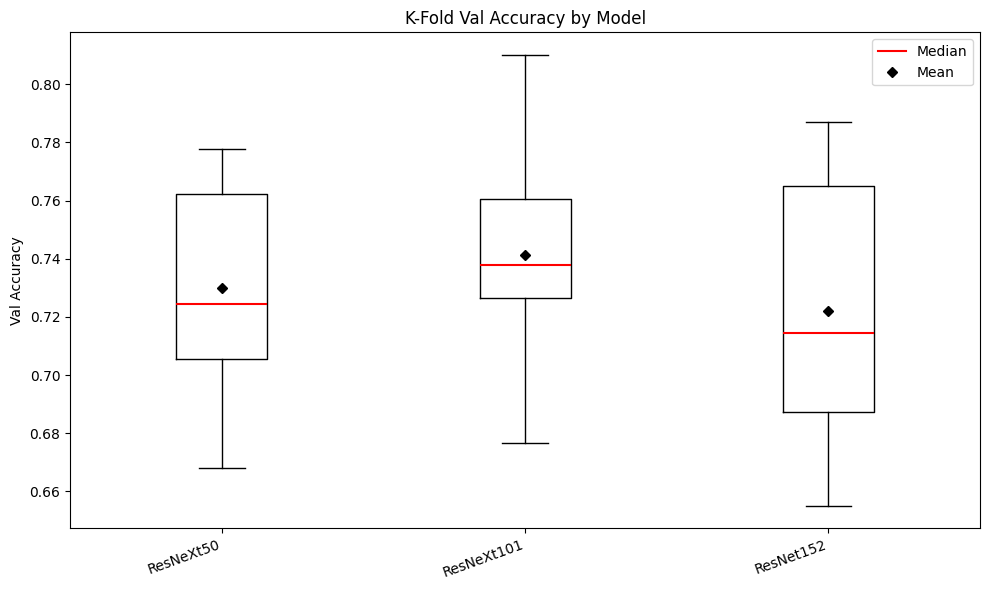

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'K-Fold Val Accuracy by Model'}, ylabel='Val Accuracy'>)

In [4]:
brain_met_plt.plot_model_comparison_boxplot(per_model_results, metric="Val Accuracy", figsize=(10, 6))

## 5) Mean ± SD: Validation Accuracy

Bars show the mean validation accuracy per model with standard‑deviation error bars (across folds).

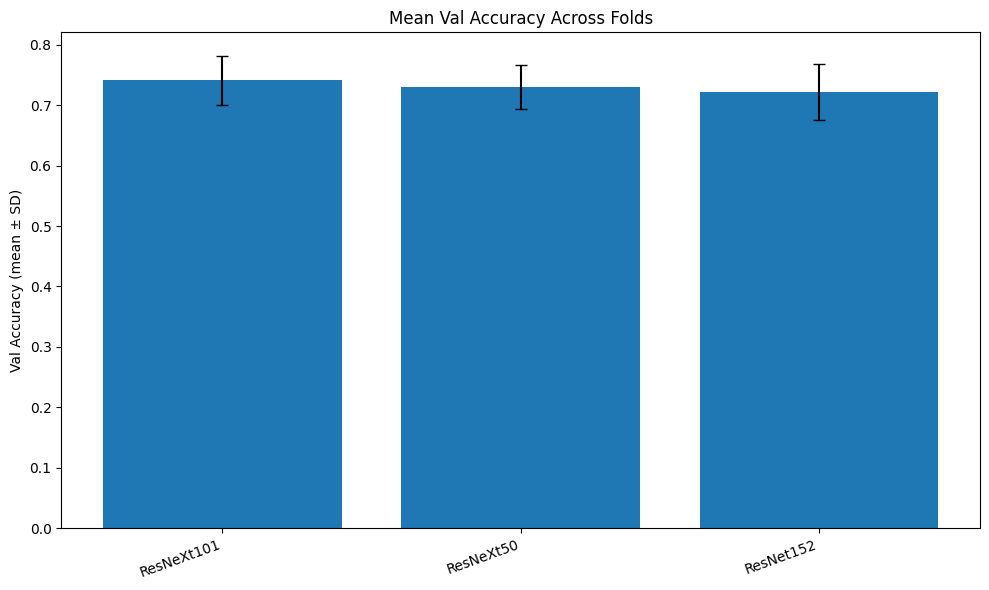


Summary statistics for Val Accuracy:
             mean    std
Model                   
ResNeXt101 0.7412 0.0406
ResNeXt50  0.7299 0.0361
ResNet152  0.7219 0.0461


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Mean Val Accuracy Across Folds'}, ylabel='Val Accuracy (mean ± SD)'>)

In [5]:
brain_met_plt.plot_model_summary_bar(combined_df, metric="Val Accuracy", figsize=(10, 6))

## 6) Mean ± SD: Overfitting Gap (Train Acc − Val Acc)

Positive values indicate the model fits training data better than validation (**overfitting**).

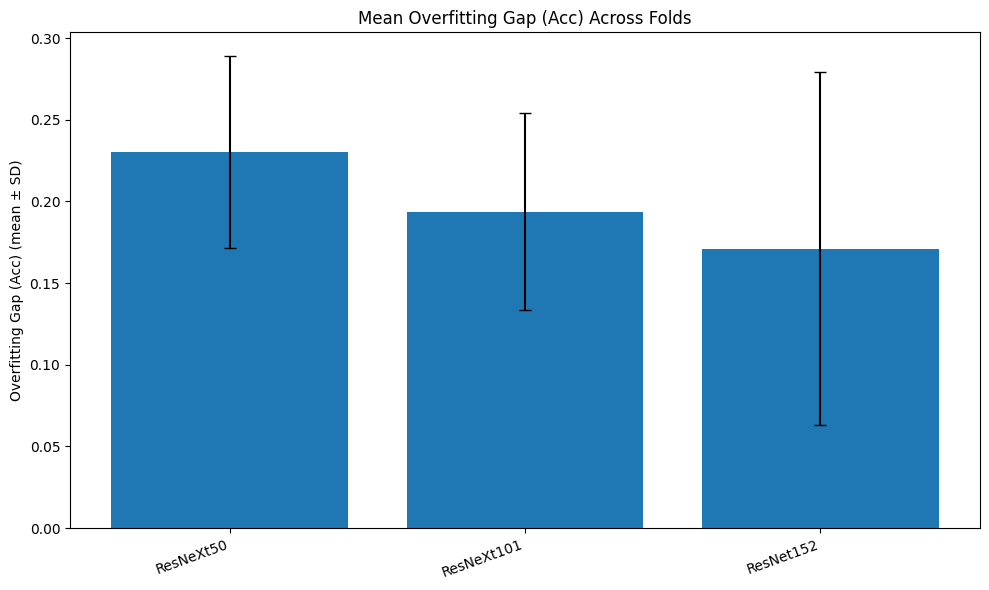


Summary statistics for Overfitting Gap (Acc):
             mean    std
Model                   
ResNeXt50  0.2303 0.0588
ResNeXt101 0.1936 0.0603
ResNet152  0.1710 0.1081


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Mean Overfitting Gap (Acc) Across Folds'}, ylabel='Overfitting Gap (Acc) (mean ± SD)'>)

In [6]:
brain_met_plt.plot_model_summary_bar(combined_df, metric="Overfitting Gap (Acc)", figsize=(10, 6))

## 7) Export combined summary to CSV

In [ ]:
brain_met_plt.save_summary_to_csv(combined_df, output_path="kfold_summary_experiment_01.csv")

---

### Notes
- Replace `MODEL_PATTERNS` with the appropriate paths for your project.
- If your model selection should be based on **minimum validation loss**, set:
  ```python
  SELECTION_METRIC = "val_loss"
  HIGHER_IS_BETTER = False
  ```
- Ensure your history files contain the necessary keys. If not, adapt the code accordingly.
- Each plot uses **matplotlib** only, with one chart per figure and default styling (no custom colors), to be compatible with strict pipelines.